In [35]:
# imports
import numpy as np
import math
import random
import os
import torch
import torch.functional as F
import scipy.spatial.distance
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

import plotly.graph_objects as go
import plotly.express as px

from path import Path
import src.visualizer as vis

In [ ]:
# farthest_point_sampling

import numpy as np


def farthest_point_sampling(arr, n_sample, start_idx=None):
    n_points, n_dim = arr.shape

    if (start_idx is None) or (start_idx < 0):
        start_idx = np.random.randint(0, n_points)

    sampled_indices = [start_idx]
    min_distances = np.full(n_points, np.inf)

    for _ in range(n_sample - 1):
        current_point = arr[sampled_indices[-1]]
        dist_to_current_point = np.linalg.norm(arr - current_point, axis=1)
        min_distances = np.minimum(min_distances, dist_to_current_point)
        farthest_point_idx = np.argmax(min_distances)
        sampled_indices.append(farthest_point_idx)

    return np.array(sampled_indices)


k = 24
point_idx = farthest_point_sampling(x.numpy(), k)
# point_idx = torch.tensor(point_idx)
clusters = x[point_idx]
print(clusters.shape)
# plot x and point_idx
E = torch.cdist(x, clusters)
F, z = torch.min(E, dim=1)
# 3d plot with labels = z
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
ax.patch.set_alpha(0.2)
ax.scatter(x[:, 0], x[:, 1], x[:, 2], c=z, alpha=0.5)
# make axis equal
ax.set_box_aspect([1, 1, 1])
# make axis not visible
ax.axis("off")
# make background alpha 0
# save image
plt.savefig("farthest_point_sampling.png")
plt.show()

In [ ]:
import matplotlib.pyplot as plt

num = 30
# argsort x based on 3rd dim

x = dataset.data[num]
# sort x based on [:, -1]
x = x[x[:, -1].argsort()][:2000]
# plot as 3d
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
ax.scatter(
    x[:, 0], x[:, 1], x[:, 2], marker="o", c=x[:, 2], cmap="viridis", alpha=0.8, s=20
)
plt.axis("off")
plt.axis("equal")
plt.show()
plt.imshow(cov_m, cmap="viridis", interpolation="nearest")
# make axis not visible and equal
plt.axis("off")
plt.axis("equal")
plt.show()
# also show variances
# variance of x
var_x = torch.var(x[:, 0])
var_y = torch.var(x[:, 1])
var_z = torch.var(x[:, 2])

In [ ]:
pcshow(*pointcloud.T)

Now we can create a [custom PyTorch Dataset](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html)

In [ ]:
# load mnist with the usual normalizations(transformations)
# load mnist

# load mnist
minist = torchvision.datasets.MNIST(
    root="data", train=True, download=True, transform=transforms.ToTensor()
)


## Dataloader and Dataset

In [2]:
# imports
import numpy as np
import math
import random
import os
import torch
import torch.functional as F
import scipy.spatial.distance
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

import plotly.graph_objects as go
import plotly.express as px

from path import Path
import src.visualizer as vis

import os
import torch
from torch.utils.data import DataLoader
from pytorch3d.io import IO
from pytorch3d.ops import sample_points_from_meshes

# Disable telemetry logging
os.environ["IOPATH_LOGGING"] = "off"

In [3]:
# load meshes
mesh_path = "./src/data/ModelNet40/airplane/train/airplane_0001.off"
mesh = IO().load_mesh(mesh_path)
# # sample points
n_points = 1024
points = sample_points_from_meshes(mesh, n_points)
print(points.shape)

torch.Size([1, 1024, 3])


In [164]:
import os
import torch
from torch.utils.data import DataLoader
from pytorch3d.io import IO
from pytorch3d.ops import sample_points_from_meshes

# Disable telemetry logging
os.environ["IOPATH_LOGGING"] = "off"


class ModelNet40Dataset(Dataset):
    def __init__(
        self,
        data_dir,
        classes_file,
        num_points=1024,
        split="train",
        transform=None,
        resampling=False,
        return_normals=False,
        normalize=True,
    ):
        self.data_dir = data_dir
        self.num_points = num_points
        self.split = split  # 'train' or 'test'
        if self.split not in ["train", "test"]:
            raise ValueError("Invalid split. Must be 'train' or 'test'.")
        self.transform = transform
        self.resampling = resampling
        self.return_normals = return_normals
        self.normalize = normalize

        # Read classes from the text file
        with open(classes_file, "r") as f:
            self.classes = f.read().splitlines()

        self.data = []
        self.labels = []

        self._load_data()

    def _load_data(self):
        for label, class_name in enumerate(self.classes):
            class_dir = os.path.join(self.data_dir, class_name, self.split)
            if not os.path.isdir(class_dir):
                print(f"Directory {class_dir} does not exist.")
                continue
            for mesh_file in os.listdir(class_dir):
                if mesh_file.endswith(".off"):
                    mesh_path = os.path.join(class_dir, mesh_file)
                    self.data.append(mesh_path)
                    self.labels.append(label)
            if len(self.data) == 0:
                print(f"No valid .off files found in {class_dir}.")
            else:
                print(f"Loaded {len(self.data)} meshes from {class_dir}.")

    def __len__(self):
        return len(self.data)

    def _normalize_point_cloud(self, point_cloud):
        mean = point_cloud.mean(dim=0)
        std = point_cloud.std(dim=0)
        point_cloud = (point_cloud - mean) / std
        return point_cloud

    def __getitem__(self, idx):
        mesh_path = self.data[idx]
        label = self.labels[idx]

        # Load the mesh
        mesh = IO().load_mesh(mesh_path)

        # Sample points from the mesh
        point_cloud, normals = sample_points_from_meshes(
            mesh, num_samples=self.num_points, return_normals=True
        )
        point_cloud = point_cloud.squeeze(0)
        point_cloud = self.transform(point_cloud) if self.transform else point_cloud
        point_cloud = (
            self._normalize_point_cloud(point_cloud) if self.normalize else point_cloud
        )

        return_tuple = (point_cloud,)
        if self.resampling:
            target_point_cloud = sample_points_from_meshes(
                mesh, num_samples=self.num_points
            ).squeeze(0)
            target_point_cloud = (
                self.transform(target_point_cloud)
                if self.transform
                else target_point_cloud
            )
            target_point_cloud = (
                self._normalize_point_cloud(target_point_cloud)
                if self.normalize
                else target_point_cloud
            )
            return_tuple += (target_point_cloud,)
        if self.return_normals:
            normals = normals.squeeze(0)
            return_tuple += (normals,)
        return_tuple += (label,)

        return return_tuple


# Define the path to your ModelNet40 dataset and classes file
data_dir = "./src/data/ModelNet40"
classes_file = "./src/data/ModelNet40/classes.txt"
# Create the dataset for the training split
train_dataset = ModelNet40Dataset(
    data_dir, classes_file, num_points=1024, split="train", resampling=True
)

# Create the dataset for the testing split
test_dataset = ModelNet40Dataset(data_dir, classes_file, num_points=1024, split="test")

# Create the dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Iterate over the train dataloader
for point_clouds, targets, labels in train_dataloader:
    print(point_clouds.shape)  # should be [batch_size, num_points, 3]
    print(labels)
    break  # just to check the first batch

# Iterate over the test dataloader
for point_clouds, labels in test_dataloader:
    print(point_clouds.shape)  # should be [batch_size, num_points, 3]
    print(labels)
    break  # just to check the first batch

Loaded 626 meshes from ./src/data/ModelNet40\airplane\train.
Loaded 732 meshes from ./src/data/ModelNet40\bathtub\train.
Loaded 1247 meshes from ./src/data/ModelNet40\bed\train.
Loaded 1420 meshes from ./src/data/ModelNet40\bench\train.
Loaded 1992 meshes from ./src/data/ModelNet40\bookshelf\train.
Loaded 2327 meshes from ./src/data/ModelNet40\bottle\train.
Loaded 2391 meshes from ./src/data/ModelNet40\bowl\train.
Loaded 2588 meshes from ./src/data/ModelNet40\car\train.
Loaded 3477 meshes from ./src/data/ModelNet40\chair\train.
Loaded 3644 meshes from ./src/data/ModelNet40\cone\train.
Loaded 3723 meshes from ./src/data/ModelNet40\cup\train.
Loaded 3861 meshes from ./src/data/ModelNet40\curtain\train.
Loaded 4061 meshes from ./src/data/ModelNet40\desk\train.
Loaded 4170 meshes from ./src/data/ModelNet40\door\train.
Loaded 4370 meshes from ./src/data/ModelNet40\dresser\train.
Loaded 4519 meshes from ./src/data/ModelNet40\flower_pot\train.
Loaded 4690 meshes from ./src/data/ModelNet40\gla

In [3]:
import os
import torch
from torch.utils.data import DataLoader
from pytorch3d.io import IO
from pytorch3d.ops import sample_points_from_meshes

# Disable telemetry logging
os.environ["IOPATH_LOGGING"] = "off"


class ModelNet40Dataset(Dataset):
    def __init__(
        self, data_dir, classes_file, num_points=1024, split="train", transform=None
    ):
        self.data_dir = data_dir
        self.num_points = num_points
        self.split = split  # 'train' or 'test'
        self.transform = transform

        # Read classes from the text file
        with open(classes_file, "r") as f:
            self.classes = f.read().splitlines()

        self.data = []
        self.labels = []

        self._load_data()

    def _load_data(self):
        for label, class_name in enumerate(self.classes):
            class_dir = os.path.join(self.data_dir, class_name, self.split)
            if not os.path.isdir(class_dir):
                print(f"Directory {class_dir} does not exist.")
                continue
            for mesh_file in os.listdir(class_dir):
                if mesh_file.endswith(".off"):
                    mesh_path = os.path.join(class_dir, mesh_file)
                    self.data.append(mesh_path)
                    self.labels.append(label)
            if len(self.data) == 0:
                print(f"No valid .off files found in {class_dir}.")
            else:
                print(f"Loaded {len(self.data)} meshes from {class_dir}.")

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        mesh_path = self.data[idx]
        label = self.labels[idx]

        # Load the mesh
        mesh = IO().load_mesh(mesh_path)

        # Sample points from the mesh
        point_cloud, normals = sample_points_from_meshes(
            mesh, num_samples=self.num_points, return_normals=True
        )
        point_cloud = point_cloud.squeeze(0)
        normals = normals.squeeze(0)  # if needed then return normals

        if self.transform:
            point_cloud = self.transform(point_cloud)

        return point_cloud, label


# Define the path to your ModelNet40 dataset and classes file
data_dir = "./src/data/ModelNet40"
classes_file = "./src/data/ModelNet40/classes.txt"

# Create the dataset for the training split
train_dataset = ModelNet40Dataset(
    data_dir, classes_file, num_points=1024, split="train"
)

# Create the dataset for the testing split
test_dataset = ModelNet40Dataset(data_dir, classes_file, num_points=1024, split="test")

# Create the dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Iterate over the train dataloader
for point_clouds, labels in train_dataloader:
    print(point_clouds.shape)  # should be [batch_size, num_points, 3]
    print(labels)
    break  # just to check the first batch

# Iterate over the test dataloader
for point_clouds, labels in test_dataloader:
    print(point_clouds.shape)  # should be [batch_size, num_points, 3]
    print(labels)
    break  # just to check the first batch

Loaded 626 meshes from ./src/data/ModelNet40\airplane\train.
Loaded 732 meshes from ./src/data/ModelNet40\bathtub\train.
Loaded 1247 meshes from ./src/data/ModelNet40\bed\train.
Loaded 1420 meshes from ./src/data/ModelNet40\bench\train.
Loaded 1992 meshes from ./src/data/ModelNet40\bookshelf\train.
Loaded 2327 meshes from ./src/data/ModelNet40\bottle\train.
Loaded 2391 meshes from ./src/data/ModelNet40\bowl\train.
Loaded 2588 meshes from ./src/data/ModelNet40\car\train.
Loaded 3477 meshes from ./src/data/ModelNet40\chair\train.
Loaded 3644 meshes from ./src/data/ModelNet40\cone\train.
Loaded 3723 meshes from ./src/data/ModelNet40\cup\train.
Loaded 3861 meshes from ./src/data/ModelNet40\curtain\train.
Loaded 4061 meshes from ./src/data/ModelNet40\desk\train.
Loaded 4170 meshes from ./src/data/ModelNet40\door\train.
Loaded 4370 meshes from ./src/data/ModelNet40\dresser\train.
Loaded 4519 meshes from ./src/data/ModelNet40\flower_pot\train.
Loaded 4690 meshes from ./src/data/ModelNet40\gla

In [ ]:
train_dataset[0]

torch.Size([1, 1024, 3])
torch.Size([1, 1024, 3])


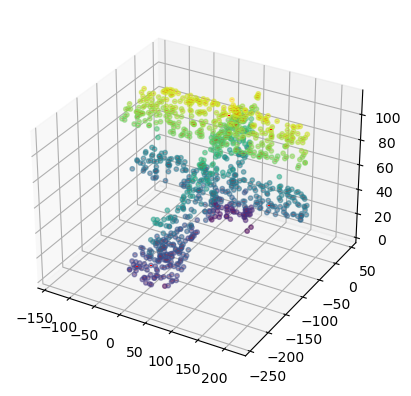

In [5]:
import torch
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from pytorch3d.io import IO
from pytorch3d.ops import sample_points_from_meshes

# Get a random mesh
mesh_path = train_dataset.data[0]

# Load mesh and normals
mesh = IO().load_mesh(mesh_path)

# Sample points and corresponding normals
n_points = 1024
points_ex, normals = sample_points_from_meshes(mesh, n_points, return_normals=True)
print(points_ex.shape)
print(normals.shape)
# normals = mesh.faces_normals_packed()[face_idxs]

# Plot point cloud and normals
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
ax.scatter(
    points_ex[..., 0],
    points_ex[..., 1],
    points_ex[..., 2],
    c=points_ex[..., 2],
    cmap="viridis",
    alpha=0.5,
    s=10,
)

# Plot normals as arrows
# for i in range(n_points):
ax.quiver(
    points_ex[..., 0],
    points_ex[..., 1],
    points_ex[..., 2],
    normals[..., 0],
    normals[..., 1],
    normals[..., 2],
    length=0.1,
    color="r",
)

plt.show()

### Get Persons

In [6]:
train_dataset.labels
train_dataset.data
# first lets get the index of person
idx = train_dataset.classes.index("person")
indices = np.where(np.array(train_dataset.labels) == idx)
# lets get the meshes of those indices
data = []
for i in indices[0]:
    point_cloud, label = train_dataset[i]
    # print(f"Lable: {label}")
    data.append(point_cloud)
print(len(data))

88


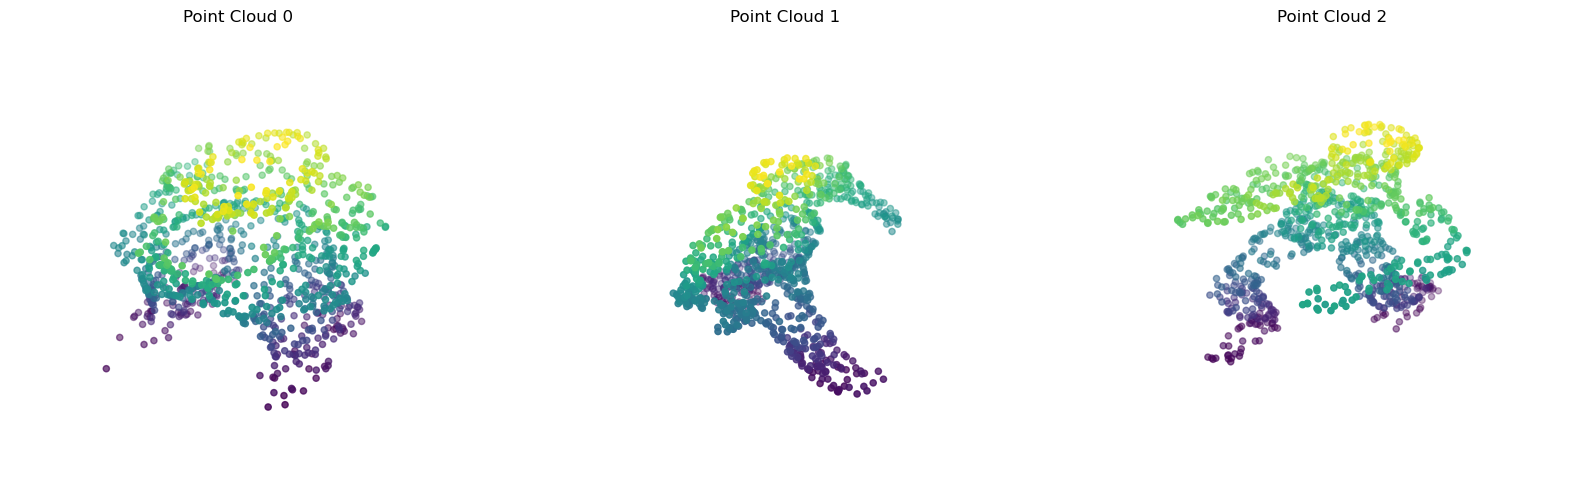

In [126]:
# lets plot the first 10 point clouds
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

num = 3
# get 5 random point clouds
data_ = random.sample(data, num)
# 3D
fig = plt.figure(figsize=(20, 20))
for i in range(num):
    ax = fig.add_subplot(1, num, i + 1, projection="3d")
    ax.scatter(
        data_[i][:, 0],
        data_[i][:, 1],
        data_[i][:, 2],
        c=data_[i][:, 2],
        s=20,
        cmap="viridis",
    )
    ax.set_title(f"Point Cloud {i}")
    ax.axis("off")
plt.show()

In [119]:
# choose a points
points = data_[0]

## FPS

Text(0.5, 0.92, 'Stochastic FPS')

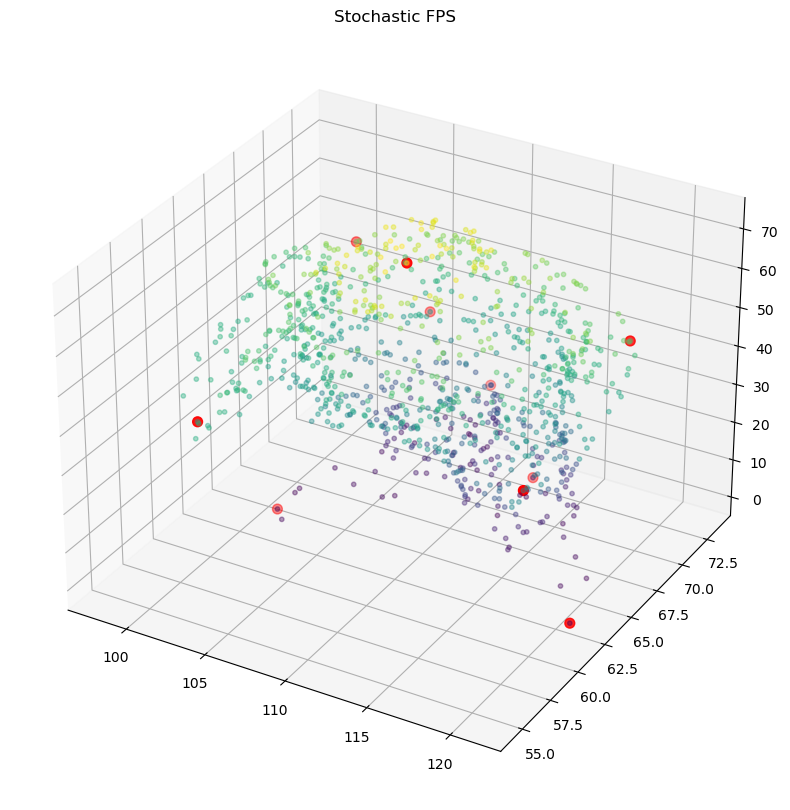

In [120]:
def stochastic_fps(point_cloud, n_sample, distance_function):
    n_points = point_cloud.shape[0]
    start_idx = np.random.randint(0, n_points)
    sampled_indices = [start_idx]
    min_distances = np.full(n_points, np.inf)

    for _ in range(n_sample - 1):
        current_point = point_cloud[sampled_indices[-1]]
        dist_to_current_point = distance_function(point_cloud, current_point)
        min_distances = np.minimum(min_distances, dist_to_current_point)
        farthest_point_idx = np.argmax(min_distances)
        sampled_indices.append(farthest_point_idx)

    return np.array(sampled_indices)


seed = 42
np.random.seed(seed)
pc = points
k = 10
point_idx = stochastic_fps(pc, k, lambda x, y: np.linalg.norm(x - y, axis=1))
# lets plot the point cloud and the sampled points
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(pc[:, 0], pc[:, 1], pc[:, 2], c=pc[:, 2], s=10, cmap="viridis", alpha=0.4)
ax.scatter(pc[point_idx, 0], pc[point_idx, 1], pc[point_idx, 2], c="r", s=50)
ax.set_title("Stochastic FPS")

In [145]:
ticks = range()
for i in ticks:
    print(i)

0
1
2
3
4
5


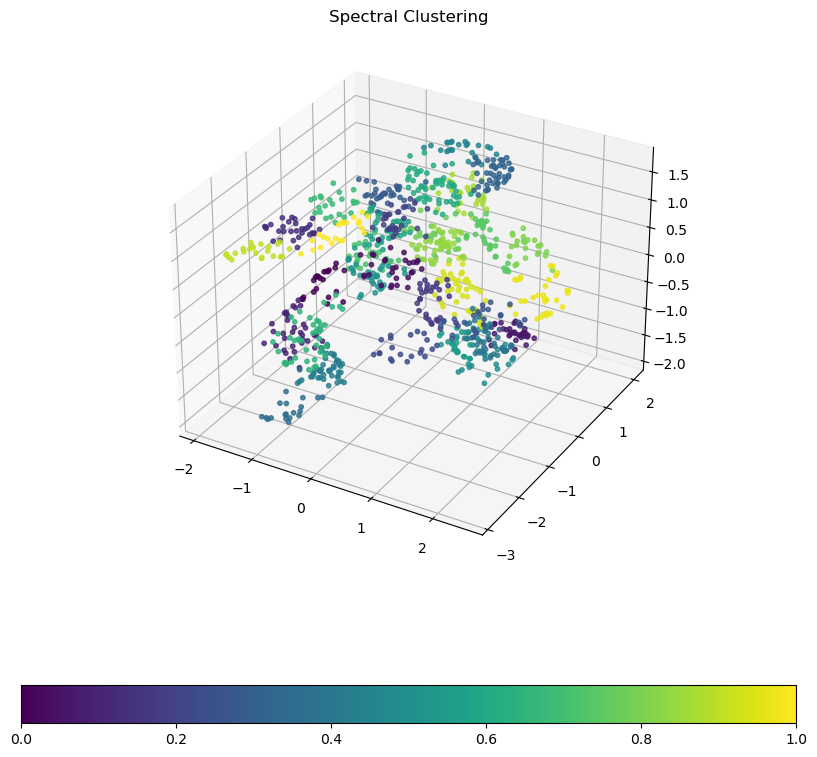

In [198]:
# lets cluster the points with spectral clustering
from sklearn.cluster import SpectralClustering
from sklearn.preprocessing import StandardScaler

# get the points
points = data_[-1]
# normalize the points
scaler = StandardScaler()
points = scaler.fit_transform(points)
# cluster the points
n_clusters = 32
clustering = SpectralClustering(
    n_clusters=n_clusters,
    assign_labels="discretize",
    affinity="nearest_neighbors",
    n_neighbors=20,
    random_state=42,
)
labels = clustering.fit_predict(points)
# plot the points with labels
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection="3d")

ax.scatter(
    points[:, 0], points[:, 1], points[:, 2], c=labels, s=10, cmap="viridis", alpha=0.8
)
# also show cmap
# plt.colorbar(  # create colorbar
#     plt.cm.ScalarMappable(cmap="viridis"), ax=ax, orientation="horizontal"
# )
# make it descrete
plt.colorbar(  # create colorbar
    plt.cm.ScalarMappable(cmap="viridis"),
    ax=ax,
    orientation="horizontal",
    # ticks=range(n_clusters + 1)
    # only sohwcase the clusters (0,0.2)
)

# rotate
# ax.view_init(0, 270)
# ax.view_init(30, 20, 90)
ax.set_title("Spectral Clustering")
plt.show()

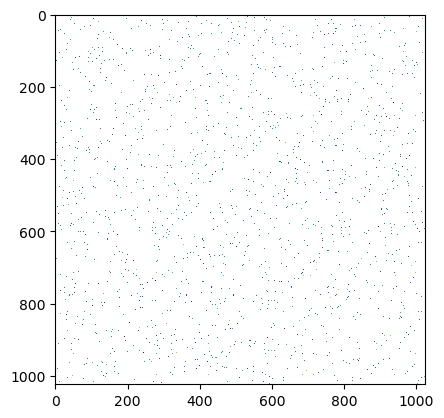

In [11]:
## take the person point cloud and do a knn graph. Then do a clustering on the graph to find the right clusters
# first import geodesic distance
import torch_geometric
import torch_geometric.transforms as T
from torch_geometric.nn import knn_graph
from torch_geometric.utils import to_undirected

# get the knn graph
k = 10
# print(points.shape)
# points = points.squeeze(0).squeeze(0)
# get knn graph based on geo_dist not euclidean
knn_graph_ = knn_graph(points, k, loop=False)
am = knn_graph_
# make am dense
am_dense = torch_geometric.utils.to_dense_adj(knn_graph_).squeeze(0)
# make adj a matrix of infinitys of shape n x n
adj = torch.full((points.shape[0], points.shape[0]), float("inf"))
for i, j in knn_graph_.T:
    adj[i, j] = torch.norm(points[i] - points[j])
    adj[j, i] = torch.norm(points[i] - points[j])

plt.imshow(adj, cmap="viridis", interpolation="nearest")

In [71]:
from scipy.sparse.csgraph import shortest_path
from torch_geometric.utils import to_dense_adj


def geo_dist(am, i, j):
    path = shortest_path(am, directed=False)
    dist = path[i, j]
    return dist


# now transform the knn_path to a geodesic path
def geo_dist(am, i, j):
    path = shortest_path(am)
    dist = path[i, j]
    return dist


def distance(am, p1, p2, pc):
    # project p1 and p2 onto manifold pc
    # do nn search on pc
    p1_idx = torch.where(pc == p1)[0][0].item()
    p1_nn = torch.argmin(torch.norm(pc - p1, dim=1))
    p1_dist = torch.norm(pc[p1_nn] - p2)
    p2_idx = torch.where(pc == p2)[0][0].item()
    p2_nn = torch.argmin(torch.norm(pc - p2, dim=1))
    p2_dist = torch.norm(pc[p2_nn] - p1)

    geo_d = geo_dist(adj.numpy(), p1_idx, p2_idx)
    return p1_dist + p2_dist + geo_d

Sampled: 1
Current Point: tensor([-168.6059,   98.0266,  871.3425])
Point: 0
Array: 1822.0836181640625
Point: 1
Array: 851.377197265625
Point: 2
Array: 289.12066650390625
Point: 3
Array: 1591.997314453125
Point: 4
Array: 2022.5003662109375
Point: 5
Array: 496.77655029296875
Point: 6
Array: 1464.543701171875
Point: 7
Array: 1430.71923828125
Point: 8
Array: 354.2048034667969
Point: 9
Array: 2184.33984375
Point: 10
Array: 1114.4517822265625
Point: 11
Array: 1542.147705078125
Point: 12
Array: 2669.137451171875
Point: 13
Array: 1378.2767333984375
Point: 14
Array: 1947.17138671875
Point: 15
Array: 954.5553588867188
Point: 16
Array: 1160.781982421875
Point: 17
Array: 1483.652099609375
Point: 18
Array: 942.5994873046875
Point: 19
Array: 2576.900390625
Point: 20
Array: 1435.527587890625
Point: 21
Array: 1265.5419921875
Point: 22
Array: 1268.194580078125
Point: 23
Array: 1840.278076171875
Point: 24
Array: 2542.872314453125
Point: 25
Array: 1322.5750732421875
Point: 26
Array: 1545.369873046875
Po

Text(0.5, 0.92, 'Stochastic FPS')

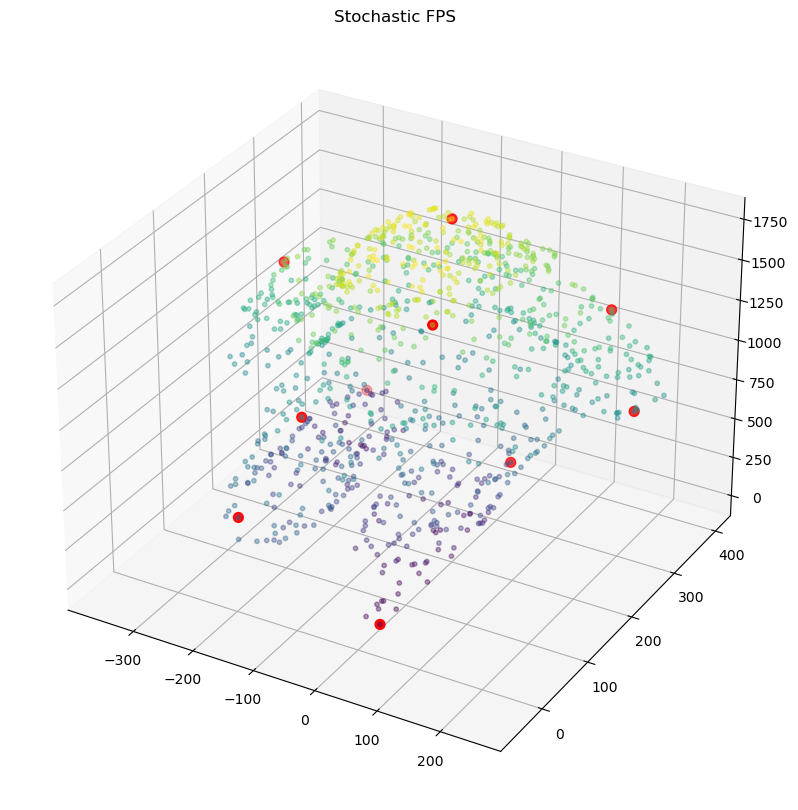

In [79]:
def distance_function_array(point_cloud, current_point):
    array = torch.full((point_cloud.shape[0],), float("inf"))
    for i in range(point_cloud.shape[0]):
        print(f"Point: {i}")
        array[i] = distance(am_dense, point_cloud[i], current_point, point_cloud)
        print(f"Array: {array[i]}")
    return array


def stochastic_fps(point_cloud, n_sample, distance_function):
    n_points = point_cloud.shape[0]
    start_idx = np.random.randint(0, n_points)
    sampled_indices = [start_idx]
    min_distances = np.full(n_points, np.inf)

    for _ in range(n_sample - 1):
        print(f"Sampled: {len(sampled_indices)}")
        current_point = point_cloud[sampled_indices[-1]]
        print(f"Current Point: {current_point}")
        dist_to_current_point = distance_function_array(point_cloud, current_point)
        print(f"Dist to current point: {dist_to_current_point.shape}")
        min_distances = np.minimum(min_distances, dist_to_current_point)
        farthest_point_idx = np.argmax(min_distances)
        sampled_indices.append(farthest_point_idx)

    return np.array(sampled_indices)


seed = 42
np.random.seed(seed)
pc = points
k = 10
point_idx = stochastic_fps(pc, k, lambda x, y: geo_dist(am_dense, x, y))
# lets plot the point cloud and the sampled points
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(pc[:, 0], pc[:, 1], pc[:, 2], c=pc[:, 2], s=10, cmap="viridis", alpha=0.4)
ax.scatter(pc[point_idx, 0], pc[point_idx, 1], pc[point_idx, 2], c="r", s=50)
ax.set_title("Stochastic FPS")

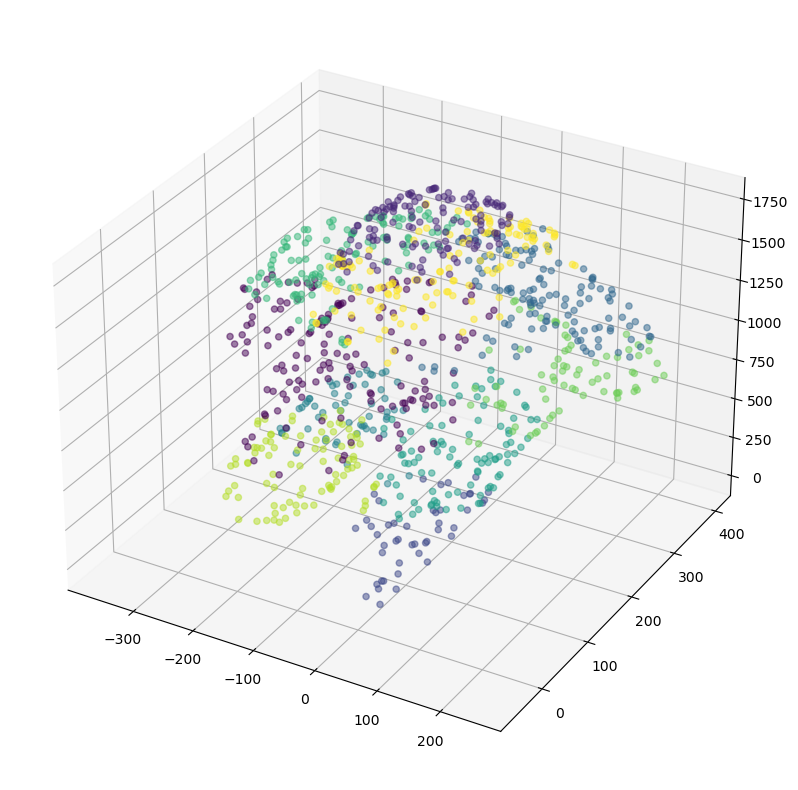

In [95]:
# lets assign poinst the pc[point_idx] (clusters)
clusters = pc[point_idx]
# cluster data
E = torch.cdist(pc, clusters)
F, z = torch.min(E, dim=1)
# 3d plot with labels = z
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(pc[:, 0], pc[:, 1], pc[:, 2], c=z, alpha=0.5)

c:\Users\panagiotis.rigas\.conda\envs\Pytorch_main\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\panagiotis.rigas\.conda\envs\Pytorch_main\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


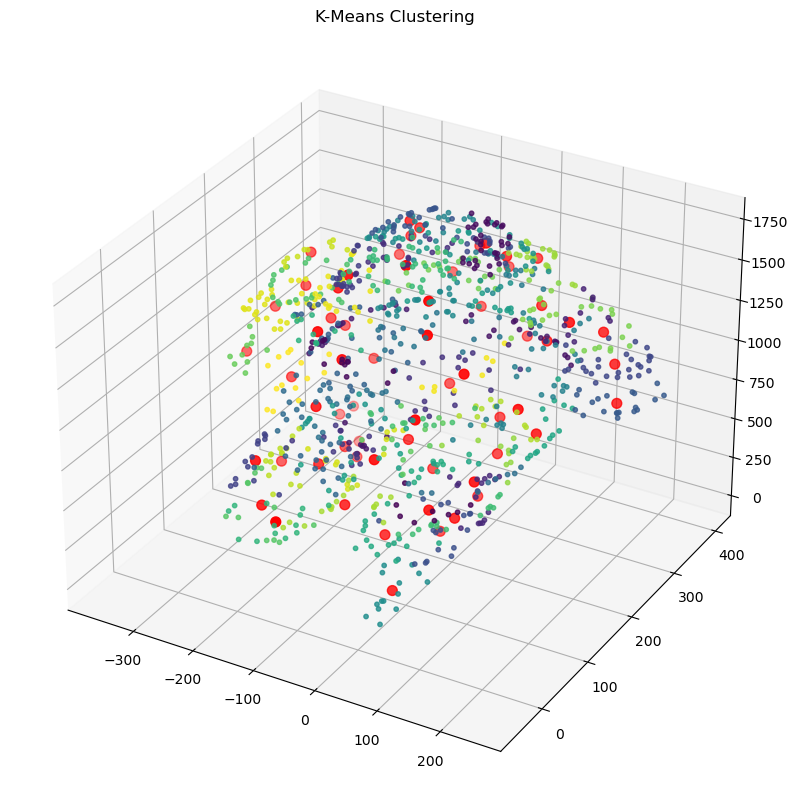

tensor([[ 62,   0,   0,  ...,   0,   0,   0],
        [  0, 105,   0,  ...,   0,   5,   0],
        [  0,   0, 292,  ...,   0,   0,   0],
        ...,
        [  0,   0,   0,  ..., 186,   0,   0],
        [  0,   8,   0,  ...,   0,  47,   0],
        [  0,   0,   0,  ...,   0,   0,  88]], dtype=torch.int32)


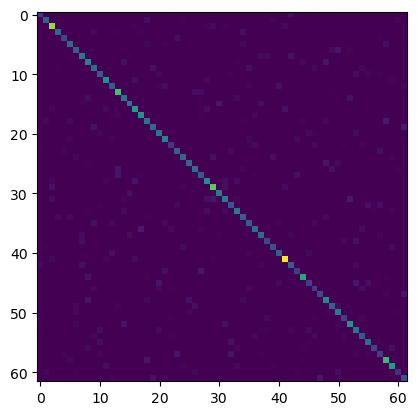

In [185]:
# lets do k-means on the point cloud
k = 62
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=k).fit(pc)
labels = kmeans.labels_
# plot
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(pc[:, 0], pc[:, 1], pc[:, 2], c=labels, s=10, cmap="viridis", alpha=0.8)
# also plot the centers
centers = kmeans.cluster_centers_
ax.scatter(centers[:, 0], centers[:, 1], centers[:, 2], c="r", s=50)
ax.set_title("K-Means Clustering")
plt.show()

import numpy as np
import torch
from collections import defaultdict

# Assuming pc is your point cloud data and labels is a tensor of labels for each point in pc
k = 10
E = torch.cdist(pc, pc)
_, indices = torch.topk(E, k, largest=False)
unique_labels = np.unique(labels)
# Initialize a dictionary to hold connectivity information
connectivity = torch.zeros((len(unique_labels), len(unique_labels)), dtype=torch.int32)

# Calculate connectivity
for i in range(pc.shape[0]):
    label = labels[i].item()
    neighbors = indices[i]
    for neighbor in neighbors:
        neighbor_label = labels[neighbor].item()
        connectivity[label, neighbor_label] += 1

# Print or return the connectivity information
print(connectivity)
# plot
plt.imshow(connectivity, cmap="viridis", interpolation="nearest")

In [207]:
cnc_top.indices

tensor([[ 0, 42, 53,  ..., 41,  1, 43],
        [ 1, 18, 39,  ..., 41, 42, 43],
        [ 2, 29, 41,  ...,  0, 42, 43],
        ...,
        [59, 11, 33,  ..., 41, 42, 43],
        [60, 50,  1,  ..., 41, 42,  0],
        [61, 47, 19,  ..., 41, 42, 43]])

In [209]:
k = 44
cnc_top = torch.topk(connectivity, k, largest=True)
# conncet clusters of topk connectivity
k = 2
connected_clusters = defaultdict(list)
for i in range(cnc_top.indices.shape[0]):
    for j in range(k):
        connected_clusters[i].append(cnc_top.indices[i, j].item())
print(connected_clusters)

defaultdict(<class 'list'>, {0: [0, 42], 1: [1, 18], 2: [2, 29], 3: [3, 34], 4: [4, 23], 5: [5, 58], 6: [6, 50], 7: [7, 42], 8: [8, 48], 9: [9, 19], 10: [10, 53], 11: [11, 16], 12: [12, 40], 13: [13, 27], 14: [14, 52], 15: [15, 30], 16: [16, 41], 17: [17, 36], 18: [18, 58], 19: [19, 61], 20: [20, 53], 21: [21, 43], 22: [22, 36], 23: [23, 57], 24: [24, 29], 25: [25, 48], 26: [26, 13], 27: [27, 13], 28: [28, 16], 29: [29, 2], 30: [30, 15], 31: [31, 52], 32: [32, 55], 33: [33, 28], 34: [34, 48], 35: [35, 9], 36: [36, 17], 37: [37, 15], 38: [38, 53], 39: [39, 24], 40: [40, 12], 41: [41, 16], 42: [42, 7], 43: [43, 27], 44: [44, 8], 45: [45, 53], 46: [46, 54], 47: [47, 61], 48: [48, 8], 49: [49, 26], 50: [50, 6], 51: [51, 54], 52: [52, 14], 53: [53, 10], 54: [54, 46], 55: [55, 32], 56: [56, 59], 57: [57, 23], 58: [58, 18], 59: [59, 11], 60: [60, 50], 61: [61, 47]})


False

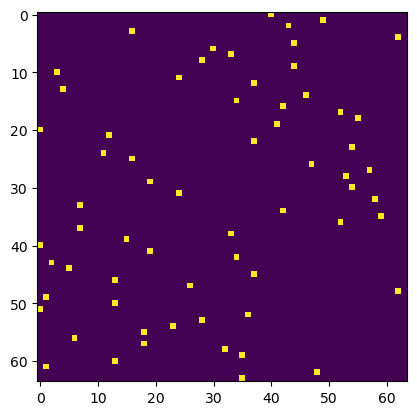

In [166]:
cnc = connectivity
# make topk in cnc
k = 2
_, indices = torch.topk(cnc, k, largest=True)
# make the indices a array
indices = indices.numpy()
# make a matrix
ind_m = np.zeros((cnc.shape[0], cnc.shape[1]))
for i in range(cnc.shape[0]):
    for j in range(k):
        if j == 0:
            continue
        ind_m[i, indices[i, j]] = 1
# plot
plt.imshow(ind_m, cmap="viridis", interpolation="nearest")

# see if ind_m is symmetric in the diagonal

In [167]:
ind_m

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [142]:
import numpy as np
import torch
from collections import defaultdict

# Assuming pc is your point cloud data and labels is an array of labels for each point in pc
k = 10
E = torch.cdist(pc, pc)
_, indices = torch.topk(E, k, largest=False)

# Initialize a dictionary to hold connectivity information
connectivity = defaultdict(lambda: defaultdict(int))

# Get unique labels
unique_labels = np.unique(labels)

# Calculate connectivity
for label in unique_labels:
    label_indices = np.where(labels == label)[0]
    for idx in label_indices:
        neighbors = indices[idx]
        neighbor_labels = labels[neighbors]
        for neighbor_label in neighbor_labels:
            connectivity[label][neighbor_label.item()] += 1

# Convert defaultdict to a regular dict for easier use/display
connectivity = {k: dict(v) for k, v in connectivity.items()}

# Print or return the connectivity information
print(connectivity)

{0: {0: 224, 34: 5, 40: 16, 20: 7, 51: 8}, 1: {1: 168, 23: 6, 61: 5, 49: 7, 45: 3, 29: 1}, 2: {2: 70, 43: 10, 8: 9, 21: 7, 22: 6, 12: 2, 41: 6}, 3: {3: 44, 10: 7, 57: 10, 42: 4, 16: 13, 47: 1, 25: 1}, 4: {4: 158, 62: 10, 13: 6, 48: 4, 32: 2}, 5: {5: 98, 44: 24, 35: 15, 63: 5, 59: 4, 9: 3, 49: 1}, 6: {6: 160, 56: 10, 9: 4, 30: 11, 54: 5}, 7: {7: 110, 26: 6, 33: 22, 10: 3, 37: 13, 22: 4, 21: 2}, 8: {8: 78, 28: 11, 43: 1, 2: 1, 53: 3, 26: 2, 47: 1, 21: 3}, 9: {9: 118, 49: 3, 54: 5, 30: 2, 5: 3, 61: 3, 35: 6, 44: 9, 36: 5, 17: 3, 6: 2, 23: 1}, 10: {10: 130, 38: 2, 41: 2, 3: 5, 7: 3, 33: 5, 57: 5, 47: 4, 55: 2, 18: 1, 26: 1}, 11: {11: 156, 48: 7, 24: 20, 20: 3, 58: 10, 32: 1, 62: 3}, 12: {12: 150, 37: 17, 21: 8, 2: 1, 22: 1, 59: 3, 45: 5, 63: 5}, 13: {13: 159, 50: 8, 4: 10, 60: 2, 46: 4, 14: 6, 31: 1}, 14: {14: 106, 13: 6, 46: 13, 31: 11, 15: 9, 51: 3, 27: 2}, 15: {15: 239, 14: 2, 0: 1, 51: 5, 34: 15, 53: 3, 39: 15}, 16: {16: 154, 3: 8, 42: 13, 40: 6, 25: 8, 60: 1}, 17: {17: 97, 52: 12, 36:

KeyError: '0'

In [137]:
labels_0 = np.where(labels == 0)
labels_1 = np.where(labels == 1)

# the connectivity between the clusters is the sum of times
# that labels_0 points appear in labels_1 top-k nearest neighbors
# and vice versa
from collections import Counter

# get the top k nearest neighbors
k = 10
E = torch.cdist(pc, pc)
_, indices = torch.topk(E, k, largest=False)
# indices are the top k nearest neighbors of each point
# so for each point in labels_0 we count the number of times
# that any point in labels_1 appears in its top k nearest neighbors

# for i in labels_0[0]:
# cnt = Counter(labels[indices[labels_0]])
cnt = labels[indices[labels_0]]
# sum over = return a vector of size = number_of laybels = 64
# for example the sum_over[0] = the self connectivity = number of 0 in cnt
# the sum_over[1] = the connectivity between label 0 and label 1 = number of 1 in cnt

1358


In [116]:
# make a distance matrix and then get the top-k distances
E = torch.cdist(pc, pc)
centers = kmeans.cluster_centers_
labels = kmeans.labels_
# top-k = adjacency matrix
k = 10
values, indices = torch.topk(E, k, largest=False)
# make centers * centers matrix with values = number of times the point is in the top-k
# show the matrix
m = torch.zeros((centers.shape[0], centers.shape[0]))
# show for example m[0, 1] = number of times the first cluster points are in the top-k of the second cluster
for i in range(centers.shape[0]):
    for j in range(centers.shape[0] - i):
        if i == j:
            continue

TypeError: sum(): argument 'input' (position 1) must be Tensor, not numpy.ndarray

## Re-sampling

In [ ]:
# enumerate

In [155]:
# lets do resampling from the same mesh
def resample_mesh(mesh, n_points):
    point_cloud = sample_points_from_meshes(mesh, num_samples=n_points).squeeze(0)
    return point_cloud


ind = 0
# load mesh
mesh_path = train_dataset.data[ind]

mesh = IO().load_mesh(mesh_path)
# torch.manual_seed(42)
# resample
points = resample_mesh(mesh, 1024)
# plot
visualise_point_cloud(points, label, 0.9, 1)

NameError: name 'visualise_point_cloud' is not defined

## Geodesic

In [350]:
# take the person point cloud and do a knn graph. Then do a clustering on the graph to find the right clusters
# first import geodesic distance
import torch_geometric.transforms as T
from torch_geometric.nn import knn_graph
from torch_geometric.utils import to_undirected

# get the knn graph
k = 2
# print(points.shape)
# points = points.squeeze(0).squeeze(0)
# get knn graph based on geo_dist not euclidean
knn_graph_ = knn_graph(points, k, loop=False)
am = knn_graph_

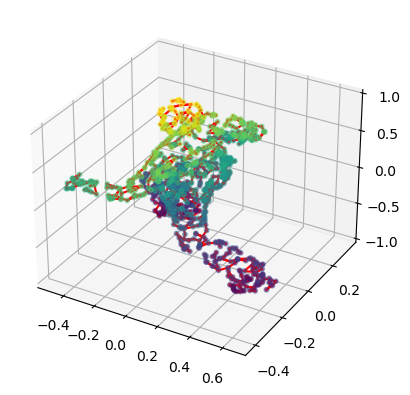

In [351]:
# plot the graph on the pointcloud
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# get the edges
edges = am
# plot
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
ax.scatter(
    points[:, 0],
    points[:, 1],
    points[:, 2],
    c=points[:, 2],
    cmap="viridis",
    s=10,
    alpha=0.5,
)
# plot the edges
for edge in edges.T:
    start = points[edge[0]]
    end = points[edge[1]]
    ax.plot([start[0], end[0]], [start[1], end[1]], [start[2], end[2]], c="r")
plt.show()

tensor([-0.0734, -0.0939, -0.0914])

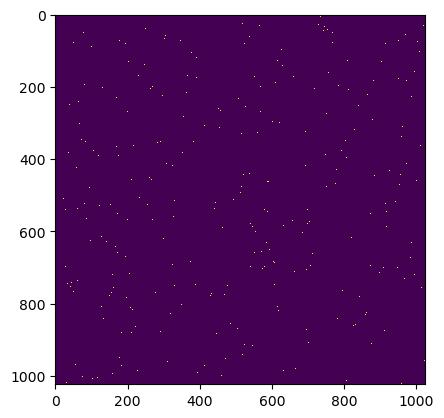

In [58]:
am_dense = torch_geometric.utils.to_dense_adj(knn_graph_).squeeze(0)
plt.imshow(am_dense, cmap="viridis", interpolation="nearest")

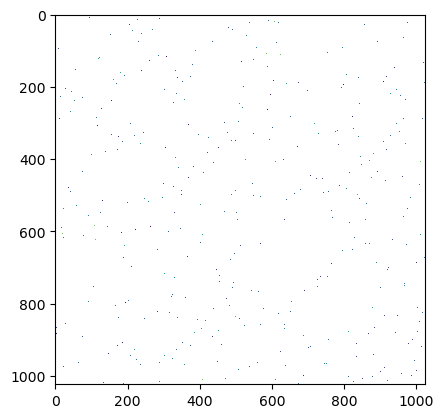

In [372]:
# adj = -torch.zeros((points.shape[0], points.shape[0]))
# make adj a matrix of infinitys of shape n x n
adj = torch.full((points.shape[0], points.shape[0]), float("inf"))

for i, j in knn_graph_.T:
    adj[i, j] = torch.norm(points[i] - points[j])
    adj[j, i] = torch.norm(points[i] - points[j])

plt.imshow(adj, cmap="viridis", interpolation="nearest")

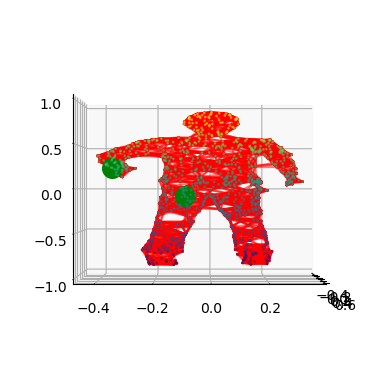

In [405]:
# plot the graph on the pointcloud
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# get the edges
edges = am
# plot
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
ax.scatter(
    points[:, 0],
    points[:, 1],
    points[:, 2],
    c=points[:, 2],
    cmap="viridis",
    s=1,
    alpha=0.5,
)
# plot the edges
for edge in edges.T:
    start = points[edge[0]]
    end = points[edge[1]]
    ax.plot(
        [start[0], end[0]], [start[1], end[1]], [start[2], end[2]], c="r", alpha=0.5
    )
num1 = 341
num = 2
p = points[num1]
q = points[num]
ax.scatter(p[0], p[1], p[2], c="g", s=200)
ax.scatter(q[0], q[1], q[2], c="g", s=200)
ax.view_init(0, 0)
plt.show()

In [408]:
from scipy.sparse.csgraph import shortest_path
from torch_geometric.utils import to_dense_adj


# now transform the knn_path to a geodesic path
def geo_dist(am, i, j):
    path = shortest_path(am, directed=False)
    dist = path[i, j]
    return dist

In [430]:
# now lets search the graph. the distance between p = pc[0] and q = pc[5] is the mean shortest path between them
# num1 = 0
# num = 47
num1 = 341
num = 2
p = points[num1]
q = points[num]
print(f"p: {p}")
print(f"q: {q}")
# print l2
l2 = torch.norm(p - q)
print(f"L2 distance: {l2}")
# print the shortest path
from scipy.sparse.csgraph import shortest_path

shortest_path = shortest_path(adj.numpy())
shortest_path = shortest_path[num1, num]
print(f"Shortest path: {shortest_path}")

p: tensor([-0.0734, -0.0939, -0.0914])
q: tensor([-0.3397, -0.3703,  0.2563])
L2 distance: 0.5179188251495361
Shortest path: 0.9786939807236195


In [436]:
from scipy.sparse.csgraph import shortest_path
from torch_geometric.utils import to_dense_adj


# now transform the knn_path to a geodesic path
def geo_dist(am, i, j):
    path = shortest_path(am)
    dist = path[i, j]
    return dist


def distance(p1, p2):
    # project p1 and p2 onto manifold pc
    # do nn search on pc
    p1_idx = torch.where(points == p1)[0][0].item()
    p1_nn = torch.argmin(torch.norm(points - p1, dim=1))
    p1_dist = torch.norm(points[p1_nn] - p2)
    p2_idx = torch.where(points == p2)[0][0].item()
    p2_nn = torch.argmin(torch.norm(points - p2, dim=1))
    p2_dist = torch.norm(points[p2_nn] - p1)
    print(f"p1_idx: {p1_idx}")
    print(f"p2_idx: {p2_idx}")
    # print distances
    print(f"p1_nn: {p1_dist}")
    print(f"p2_nn: {p2_dist}")

    geo_d = geo_dist(adj.numpy(), p1_idx, p2_idx)
    return p1_dist + p2_dist + geo_d


p1 = points[num1]
p2 = points[num]
distance(p, q)

p1_idx: 341
p2_idx: 2
p1_nn: 0.5179188251495361
p2_nn: 0.5179188251495361


tensor(2.0145)

In [409]:
# lets do k-means clustering on the graph
k = 10


# am is the adjacency matrix
# lets do k-means
class GreedyKCenter:
    def __init__(self, points, k, am):
        self.points = points
        self.k = k
        self.am = am
        self.centers = []
        self.clusters = []

    def distance(self, p1, p2):
        # project p1 and p2 onto manifold pc
        # do nn search on pc
        p1_idx = torch.where(self.points == p1)
        p1_nn = torch.argmin(torch.norm(self.points - p1, dim=1))
        p1_dist = torch.norm(self.points[nn] - p2)
        p2_idx = torch.where(self.points == p2)
        p2_nn = torch.argmin(torch.norm(self.points - p2, dim=1))
        p2_dist = torch.norm(self.points[nn] - p1)
        p2_idx = torch.where(self.points == p2)
        geo_d = geo_dist(self.am, p1_idx, p2_idx)
        return p1_dist + p2_dist + geo_d

    def initialize(self):
        # initialize the first center
        self.centers.append(self.points[0])
        # initialize the rest of the centers
        for i in range(1, self.k):
            max_dist = 0
            max_point = None
            for point in self.points:
                min_dist = float("inf")
                for center in self.centers:
                    dist = self.distance(point, center)
                    min_dist = min(min_dist, dist)
                if min_dist > max_dist:
                    max_dist = min_dist
                    max_point = point
            self.centers.append(max_point)

    def assign(self):
        for point in self.points:
            min_dist = float("inf")
            min_center = None
            for center in self.centers:
                dist = self.distance(point, center)
                if dist < min_dist:
                    min_dist = dist
                    min_center = center
            self.clusters.append(min_center)

    def fit(self):
        self.initialize()
        self.assign()
        return self.clusters

SyntaxError: invalid syntax (4015287364.py, line 5)

In [403]:
# take the person point cloud and do a knn graph. Then do a clustering on the graph to find the right clusters
# first import geodesic distance
import torch_geometric.transforms as T
from torch_geometric.nn import knn_graph
from torch_geometric.utils import to_undirected

# get the knn graph
k = 10
# print(points.shape)
# points = points.squeeze(0).squeeze(0)
# get knn graph based on geo_dist not euclidean
knn_graph_ = knn_graph(points, k, loop=False)
am = knn_graph_
adj = torch.full((points.shape[0], points.shape[0]), float("inf"))
for i, j in knn_graph_.T:
    adj[i, j] = torch.norm(points[i] - points[j])
    adj[j, i] = torch.norm(points[i] - points[j])

In [424]:
# now lets search the graph. the distance between p = pc[0] and q = pc[5] is the mean shortest path between them
# num1 = 0
# num = 47
num1 = 341
num = 2
p = points[num1]
q = points[num]
print(f"p: {p}")
print(f"q: {q}")
# print l2
l2 = torch.norm(p - q)
print(f"L2 distance: {l2}")
# print the shortest path
from scipy.sparse.csgraph import shortest_path

shortest_path = shortest_path(adj.numpy())
shortest_path = shortest_path[num1, num]
print(f"Shortest path: {shortest_path}")

p: tensor([-0.0734, -0.0939, -0.0914])
q: tensor([-0.3397, -0.3703,  0.2563])
L2 distance: 0.5179188251495361
Shortest path: 0.9786939807236195


In [346]:
am

tensor([[   0,  572,    1,  ...,  673, 1023,  509],
        [   0,    0,    1,  ..., 1022, 1023, 1023]])

In [285]:
print(am.shape)
am = torch_geometric.utils.to_dense_adj(knn_graph_).squeeze(0)
print(am.shape)

torch.Size([2, 2048])
torch.Size([1024, 1024])
